In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

In [3]:
# Create final dataset

df1 = pd.read_csv('final_50_100.csv')
df2 = pd.read_csv('final_50.csv')

combined_df = pd.concat([df1, df2], ignore_index=True)

combined_df.to_csv('final_dataset_100.csv', index=False)

# Check how many songs


df = pd.read_csv('final_dataset_100.csv')

unique_songs = df[['Artist', 'name']].drop_duplicates()

num_unique_songs = len(unique_songs)

print(f"Number of unique songs: {num_unique_songs}")


Number of unique songs: 4705


# Tokenize lyrics

In [4]:
df = pd.read_csv('final_dataset_100.csv')


# download NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # required for lemmatizer
nltk.download('omw-1.4')  # lemmatizer resource


# stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

# Tokenization + Stopwords + Lemmatization + Deduplication
def clean_tokenize_unique(lyrics):
    if pd.isna(lyrics):
        return []
    tokens = word_tokenize(lyrics)
    tokens = [t.lower() for t in tokens if t.isalpha()]  # remove non-alphabetic tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]  # lemmatize and remove stopwords

    # Remove duplicates
    seen = set()
    unique_tokens = []
    for t in tokens:
        if t not in seen:
            seen.add(t)
            unique_tokens.append(t)
    return unique_tokens

# Apply cleaned tokenization
df['tokens'] = df['lyrics'].apply(clean_tokenize_unique)



# Reorder columns so tokens come before lyrics, beacuse we dont want them as the last thing
lyrics_index = df.columns.get_loc('lyrics')
cols = list(df.columns)
cols.insert(lyrics_index, cols.pop(cols.index('tokens')))
df = df[cols]

# save
df.to_csv('final_dataset_tokens.csv', index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claralouisebrodt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claralouisebrodt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/claralouisebrodt/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/claralouisebrodt/nltk_data...


In [5]:
df = pd.read_csv("final_dataset_tokens.csv")
df


,Artist,name,artists,popularity,duration_ms,release_year,songwriters,tokens,lyrics
0,the chainsmokers,Something Just Like This,"['the chainsmokers', 'coldplay']",90.0,247160.0,2017,"['jonny buckland', 'will champion', 'chris mar...","['reading', 'book', 'old', 'legend', 'myth', '...","I've been reading books of old, the legends an..."
1,the chainsmokers,Paris,['the chainsmokers'],82.0,221506.0,2017,['elijah the alchemist'],"['stayin', 'paris', 'get', 'away', 'parent', '...",We were stayin' in Paris\nTo get away from you...
2,the chainsmokers,This Feeling,"['the chainsmokers', 'kelsea ballerini']",74.0,197946.0,2018,"['travis barker', 'tom delonge', 'mark hoppus']","['tell', 'story', 'lay', 'reason', 'say', 'nee...",I'll tell you a story before it tells itself\n...
3,the chainsmokers,Jungle,"['alok', 'the chainsmokers', 'mae stephens']",74.0,175500.0,2023,"['the motels', 'the motels']","['feeling', 'lonely', 'scared', 'letting', 'ke...","I'm out, feeling lonely again\nAm I too scared..."
4,the chainsmokers,Takeaway,"['the chainsmokers', 'illenium', 'lennon stella']",72.0,209880.0,2019,NaN,"['heart', 'takeaway', 'yeah', 'hey', 'think', ...","Your heart for takeaway, yeah, yeah, yeah-yeah..."
...,...,...,...,...,...,...,...,...,...
4700,jason derulo,Animal (R3HAB VIP Remix),"['r3hab', 'jason derulo']",39.0,155586.0,2024,['bernard grancher'],[],NaN
4701,jason derulo,Kama Sutra (feat. Kid Ink),"['jason derulo', 'kid ink']",39.0,216166.0,2013,"['jason derulo', 'hitmaka', 'breyan isaac', 'k...","['yeah', 'could', 'mustard', 'beat', 'hoe', 'c...","Yeah, yeah\nWe could, we could\nMustard on the..."
4702,jason derulo,Nu King,['jason derulo'],38.0,94280.0,2024,"['måns asplund', 'blaise', 'jason diakité']","['jason', 'derulo', 'wan', 'na', 'run', 'away'...",Jason Derulo\nWith you\nWhy you wanna run away...
4703,jason derulo,Mad Love,"['jason derulo', 'youngboy never broke again']",38.0,210813.0,2024,"['diztortion', 'david guetta', 'jack patterson...","['girl', 'love', 'affect', 'whole', 'mood', 's...","Girl, I love how you affect my whole mood\n'Ca..."


# Token analysis

### TF - IDF

In [6]:
# Join tokens to text per song
df["tokens"] = df["tokens"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else [])
df["joined_tokens"] = df["tokens"].apply(lambda x: " ".join(x))

# Compute TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["joined_tokens"])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [7]:
# Top 5 words with highest TF-IDF in first song
top_tokens = tfidf_df.iloc[0].sort_values(ascending=False).head(5)
print(top_tokens)


unrolls     0.230487
myth        0.219823
hercules    0.212257
batman      0.212257
achilles    0.206388
Name: 0, dtype: float64


### Top 20 most common words overall

In [8]:
# Flatten all tokens into a single list
all_tokens = [token for sublist in df["tokens"] for token in sublist]
token_counts = Counter(all_tokens)

# Most common words
top_common = token_counts.most_common(20)
print(top_common)


[('like', 2559), ('know', 2524), ('got', 2276), ('get', 1948), ('yeah', 1947), ('love', 1806), ('go', 1804), ('na', 1711), ('time', 1667), ('oh', 1611), ('one', 1608), ('let', 1563), ('make', 1504), ('see', 1495), ('ca', 1480), ('say', 1474), ('baby', 1452), ('never', 1448), ('take', 1412), ('back', 1411)]


### Wordcloud

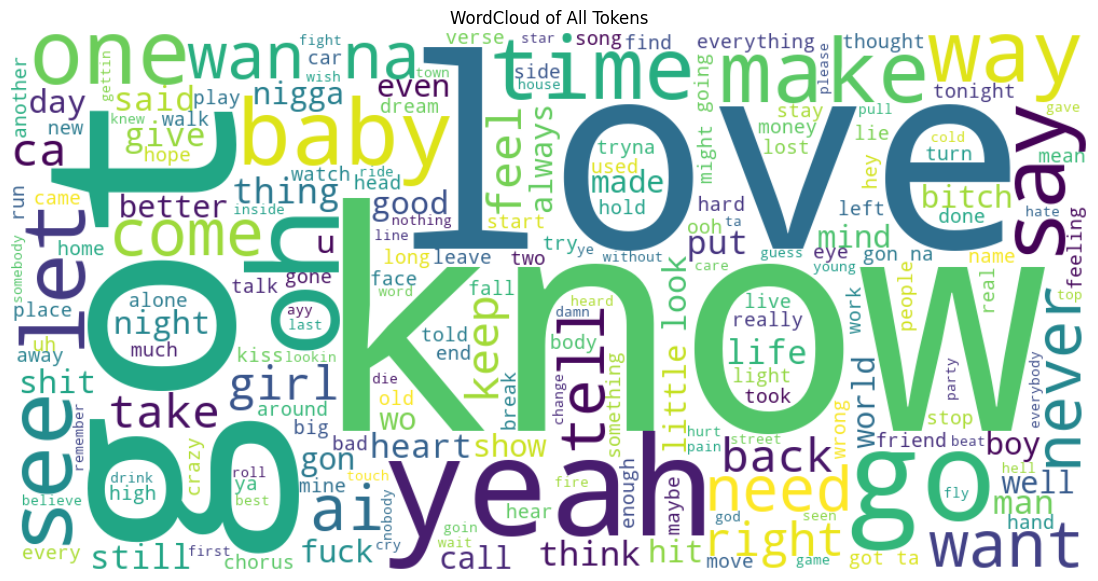

In [9]:
# Join all tokens for the WordCloud
all_text = " ".join(df["joined_tokens"])

# Generate and plot WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of All Tokens")
plt.show()


Sky 